In [1]:
import numpy as np
import pandas as pd

import timeit
import dataPreprocessing as dp

from sklearn.ensemble import RandomForestClassifier

In [2]:
path = '/Users/nikhilsawal/OneDrive/machine_learning/data_science_case_studies/buildzoom/data/'

train_x = pd.read_table(path + 'train_data.csv')
test_x = pd.read_table(path + 'xtest_data.csv')
test_y = pd.read_csv(path + 'ytest_pred.csv')

In [3]:
X_train, y_train, X_test, y_test, X_val, y_val = dp.machine_learning_prep(train_x, test_x, test_y)

In [4]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(75117, 14973)
(25148, 14973)
(25039, 14973)


# 1. Baseline Model - Random Forest

In [25]:
start = timeit.default_timer()

rfClassifier = RandomForestClassifier(n_estimators=500,
                                      max_depth=20,
                                      random_state=1002)
rfClassifier = rfClassifier.fit(X_train[:,1:2], y_train)

stop = timeit.default_timer()

print(stop-start)

3.1682121569992887


In [26]:
dp.get_scores(rfClassifier, X_val[:,1:2], y_val, X_test[:,1:2], y_test)

Validation Set Metrics: 
-----------------------
Confusion matrix: 
 [[17782    95]
 [ 2230  4932]]

F1 Score:  0.8092542456313069

Precision:  0.9811020489357469

Accuracy:  0.9071448540277167

Recall/Sensitivity:  0.688634459648143

Specificity:  0.994685909268893


Test Set Metrics: 
-----------------
Confusion matrix: 
 [[15352  2866]
 [ 4760  2170]]

F1 Score:  0.3626943005181347

Precision:  0.4308975377283558

Accuracy:  0.6967552091617624

Recall/Sensitivity:  0.31313131313131315

Specificity:  0.8426830607091887


# 2. Lasso

In [9]:
from sklearn.linear_model import Lasso

In [10]:
l2_regressor = Lasso(alpha=0.1)
l2_regressor.fit(X_train, y_train)

Lasso(alpha=0.1)

In [49]:
imp_features_l2 = [i>0.0 for i in l2_regressor.coef_]

In [52]:
X_train_l2 = X_train[:,imp_features_l2]
X_val_l2 = X_val[:,imp_features_l2]
X_test_l2 = X_test[:,imp_features_l2]

In [53]:
start = timeit.default_timer()

rfClassifier_l2 = RandomForestClassifier(n_estimators=100,
                                      max_depth=20,
                                      random_state=1002)
rfClassifier_l2 = rfClassifier_l2.fit(X_train_l2, y_train)

stop = timeit.default_timer()

print(stop-start)

0.6930415669994545


In [54]:
dp.get_scores(rfClassifier_l2, X_val_l2, y_val, X_test_l2, y_test)

Validation Set Metrics: 
-----------------------
Confusion matrix: 
 [[17782    95]
 [ 2230  4932]]

F1 Score:  0.8092542456313069

Precision:  0.9811020489357469

Accuracy:  0.9071448540277167

Recall/Sensitivity:  0.688634459648143

Specificity:  0.994685909268893


Test Set Metrics: 
-----------------
Confusion matrix: 
 [[15352  2866]
 [ 4760  2170]]

F1 Score:  0.3626943005181347

Precision:  0.4308975377283558

Accuracy:  0.6967552091617624

Recall/Sensitivity:  0.31313131313131315

Specificity:  0.8426830607091887


# 3. Ridge

In [4]:
from sklearn.linear_model import Ridge

In [5]:
start = timeit.default_timer()

l1_regressor = Ridge(alpha=0.1, random_state=1002)
l1_regressor.fit(X_train, y_train)
stop = timeit.default_timer()

print(stop-start)

Ridge(alpha=0.1)

In [18]:
imp_features = [i for i in range(len(l1_regressor.coef_)) if l1_regressor.coef_[i]>0.0]

In [20]:
len(imp_features)

5960

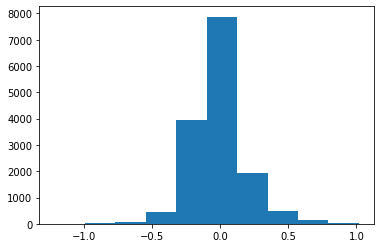

In [13]:
import matplotlib.pyplot as plt

plt.hist(l1_regressor.coef_)
plt.show()

In [21]:
X_train_l1 = np.take(X_train, imp_features, axis=1)
X_val_l1 = np.take(X_val, imp_features, axis=1)
X_test_l1 = np.take(X_test, imp_features, axis=1)

In [27]:
X_train_l1.shape[1]*0.3

1788.0

In [23]:
start = timeit.default_timer()

rfClassifier_l1 = RandomForestClassifier(n_estimators=100,
                                      max_depth=40,
                                      random_state=1002)
rfClassifier_l1 = rfClassifier_l1.fit(X_train_l1, y_train)

stop = timeit.default_timer()

print(stop-start)

451.710315113


In [24]:
dp.get_scores(rfClassifier_l1, X_val_l1, y_val, X_test_l1, y_test)

Validation Set Metrics: 
-----------------------
Confusion matrix: 
 [[17805    72]
 [  527  6635]]

F1 Score:  0.9568101521378615

Precision:  0.9892649470702252

Accuracy:  0.9760773193817645

Recall/Sensitivity:  0.926417201898911

Specificity:  0.9959724786037926


Test Set Metrics: 
-----------------
Confusion matrix: 
 [[14303  3915]
 [ 4156  2774]]

F1 Score:  0.40737205374843966

Precision:  0.414710719091045

Accuracy:  0.6790599650071576

Recall/Sensitivity:  0.4002886002886003

Specificity:  0.7851026457349873


# 4. Hyper parameter tuning

## 4.1 RandomSearchCV

## 4.2 BayesianSearchCV

In [100]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

In [103]:
# Round 1
start = timeit.default_timer()

param_grid = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(10, 60),
    'max_features': Real(0.3, 0.7, prior='uniform'),
    'max_samples': Real(0.3, 0.7, prior='uniform'),
    'criterion': Categorical[('gini', 'entropy')]
}

# # Round 2
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [20, 40, 60],
#     'max_features': [0.3, 0.5, 0.7],
#     'max_samples': [0.3, 0.5, 0.7],
#     'criterion': ['gini', 'entropy']
# }

# # Round 3
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [20, 40, 60],
#     'max_features': [0.3, 0.5, 0.7],
#     'max_samples': [0.3, 0.5, 0.7],
#     'criterion': ['gini', 'entropy']
# }

rfClassifier = RandomForestClassifier(
                                         random_state=1002,
                                         bootstrap=True
                                     )

optimal_params = BayesSearchCV(
                                  estimator=rfClassifier,
                                  search_spaces=param_grid,
                                  cv=4,
                                  n_iter=1,
                                  random_state=1002,
                                  scoring='roc_auc'
                               )

optimal_params.fit(X_train_l1, y_train)
best_accuracy = optimal_params.best_score_
best_parameters = optimal_params.best_params_

stop = timeit.default_timer()

print('Runtime: ', stop-start)
print('Best ROC-AUC: {:.2f} %'.format(best_accuracy*100))
print('Best Parameters: ', best_parameters)

Runtime:  8087.533503952
Best ROC-AUC: 99.12 %
Best Parameters:  OrderedDict([('max_depth', 11), ('max_features', 0.4607362985871365), ('max_samples', 0.42950666023840905)])


In [105]:
(stop-start) / 3600

2.246537084431111

In [106]:
rfClassifier_opt = RandomForestClassifier(
                                             random_state=1002,
                                             bootstrap=True,
                                             max_depth=11,
                                             max_features=0.46,
                                             max_samples=0.43
                                         )


rfClassifier_opt = rfClassifier_opt.fit(X_train_l1, y_train)
dp.get_scores(rfClassifier_opt, X_val_l1, y_val, X_test_l1, y_test)

Validation Set Metrics: 
-----------------------
Confusion matrix: 
 [[17742   135]
 [  669  6493]]

F1 Score:  0.9416968817984046

Precision:  0.9796318648159325

Accuracy:  0.9678900914573265

Recall/Sensitivity:  0.9065903378944429

Specificity:  0.9924483973821111


Test Set Metrics: 
-----------------
Confusion matrix: 
 [[14283  3935]
 [ 4188  2742]]

F1 Score:  0.40302785331079594

Precision:  0.4106634716189906

Accuracy:  0.6769922061396533

Recall/Sensitivity:  0.3956709956709957

Specificity:  0.7840048303875288
